scikit-learn version: 1.5.1
Loading dataset ...
Loaded dataset shape: (28242, 8)


,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485,121.0,16.37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  int64  
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1.7+ MB


None

Unnamed: 0                       0
Area                             0
Item                             0
Year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64
Using features: ['Unnamed: 0', 'Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']


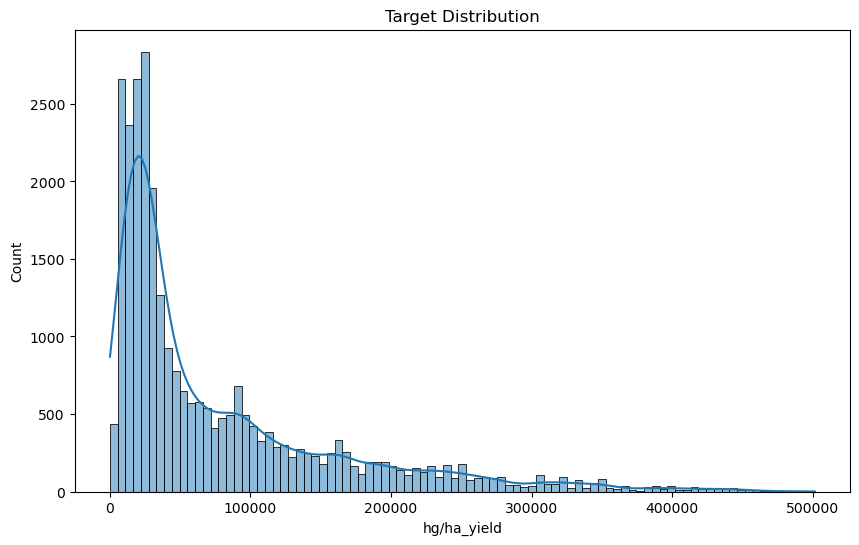

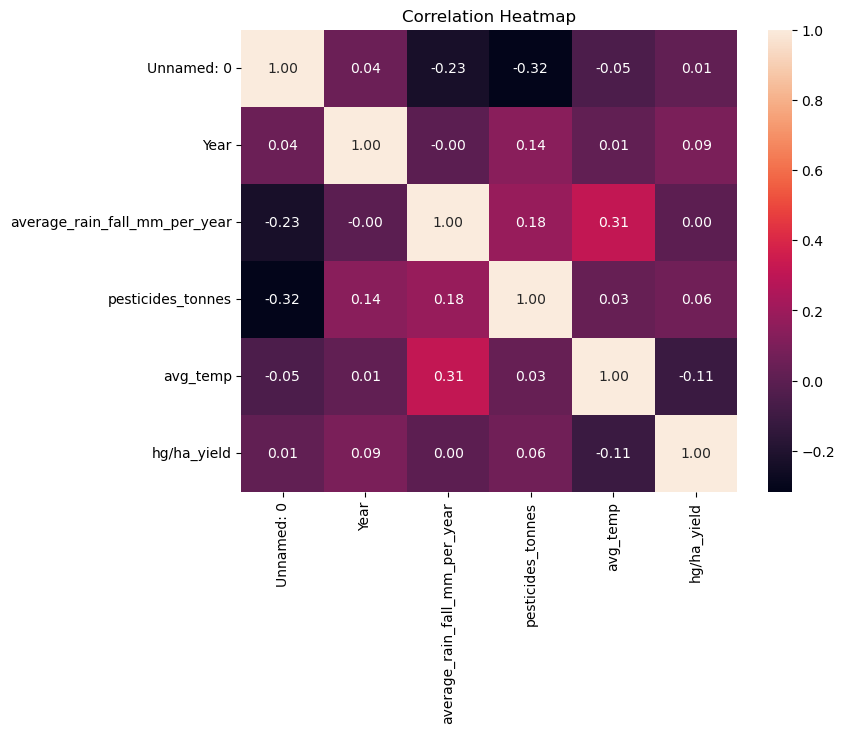

Train/Test: (22593, 6) (5649, 6)
XGBoost loaded.

Training model: LinearRegression
LinearRegression metrics: R2=0.0289, RMSE=83928.5410, MAE=64095.0270

Training model: RandomForest
RandomForest metrics: R2=0.1855, RMSE=76865.5155, MAE=49864.1499

Training model: XGBoost
XGBoost metrics: R2=-0.0618, RMSE=87762.0946, MAE=66060.4271

Model comparison:
               Model        R2           MSE          RMSE           MAE
1      RandomForest  0.185474  5.908307e+09  76865.515489  49864.149938
0  LinearRegression  0.028906  7.044000e+09  83928.540956  64095.026972
2           XGBoost -0.061833  7.702185e+09  87762.094608  66060.427129


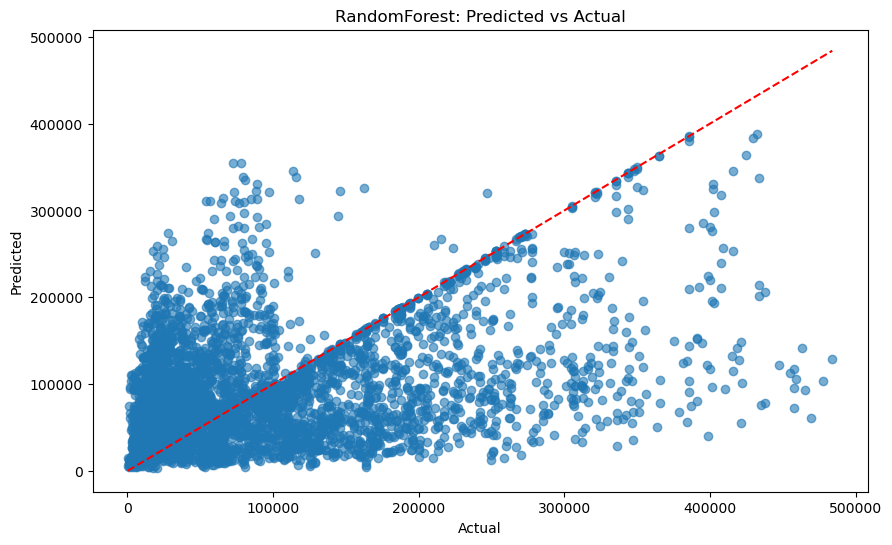

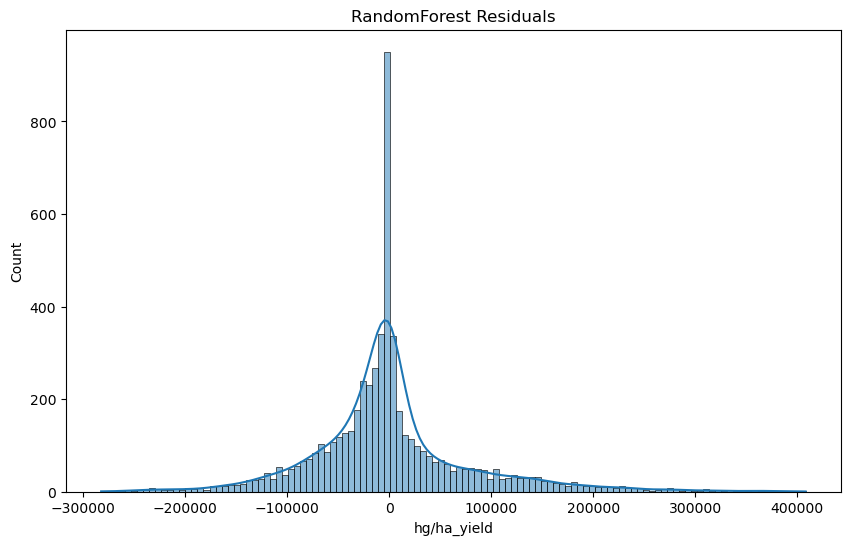


5-fold cross-validation for best model:
CV R2 mean: -0.0737 std: 0.075
Saved model: models/RandomForest_pipeline_20251101_203328.pkl
No new sample provided.


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import sklearn
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)

print("scikit-learn version:", sklearn.__version__)

DATA_PATH = "yield_df.csv"      # path to your dataset
TARGET_COL = "hg/ha_yield"      # your target column
FEATURES = None                 # or list of features if you want manual

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at: {DATA_PATH}")

print("Loading dataset ...")
data = pd.read_csv(DATA_PATH)
print("Loaded dataset shape:", data.shape)
display(data.head())

if TARGET_COL not in data.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found! Columns: {list(data.columns)}")

display(data.info())
print(data.isnull().sum().sort_values(ascending=False).head(15))

if FEATURES is None:
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    FEATURES = [c for c in numeric_cols if c != TARGET_COL]
print("Using features:", FEATURES)

df = data.copy()
df.drop_duplicates(inplace=True)
df = df.dropna(subset=[TARGET_COL])

num_cols = [c for c in FEATURES if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in FEATURES if c not in num_cols]

for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    df[c] = df[c].fillna("Unknown")

plt.figure()
sns.histplot(df[TARGET_COL], kde=True)
plt.title("Target Distribution")
plt.show()

corr = df[num_cols + [TARGET_COL]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

df_fe = df.copy()
if "avg_temp" in df_fe.columns:
    df_fe["temp_sq"] = df_fe["avg_temp"]**2
    FEATURES.append("temp_sq")

X = df_fe[FEATURES]
y = df_fe[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train/Test:", X_train.shape, X_test.shape)

skl_ver = tuple(map(int, sklearn.__version__.split(".")[:2]))
ohe_kwargs = {"handle_unknown": "ignore"}
if skl_ver >= (1,2):
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(**ohe_kwargs))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

models = {
    "LinearRegression": Pipeline([
        ("preproc", preprocessor),
        ("lr", LinearRegression())
    ]),
    "RandomForest": Pipeline([
        ("preproc", preprocessor),
        ("rf", RandomForestRegressor(n_estimators=200, random_state=42))
    ])
}

try:
    import xgboost as xgb
    models["XGBoost"] = Pipeline([
        ("preproc", preprocessor),
        ("xgb", xgb.XGBRegressor(n_estimators=200, random_state=42))
    ])
    print("XGBoost loaded.")
except Exception as e:
    print("XGBoost not available:", e)

def metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = []
predictions = {}

for name, pipeline in models.items():
    print(f"\nTraining model: {name}")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    m = metrics(y_test, y_pred)
    results.append({"Model": name, **m})
    predictions[name] = y_pred
    print(f"{name} metrics: R2={m['R2']:.4f}, RMSE={m['RMSE']:.4f}, MAE={m['MAE']:.4f}")

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print("\nModel comparison:\n", results_df)

best_model_name = results_df.iloc[0]["Model"]
best_pipeline = models[best_model_name]
y_pred_best = predictions[best_model_name]

plt.figure()
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"{best_model_name}: Predicted vs Actual")
plt.show()

residuals = y_test - y_pred_best
plt.figure()
sns.histplot(residuals, kde=True)
plt.title(f"{best_model_name} Residuals")
plt.show()

print("\n5-fold cross-validation for best model:")
cv = cross_val_score(best_pipeline, X, y, cv=5, scoring="r2")
print("CV R2 mean:", round(cv.mean(), 4), "std:", round(cv.std(), 4))

os.makedirs("models", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"models/{best_model_name}_pipeline_{timestamp}.pkl"
joblib.dump(best_pipeline, model_path)
print("Saved model:", model_path)

new_sample = {
}

if new_sample:
    sample_df = pd.DataFrame([new_sample])
    pred = best_pipeline.predict(sample_df)[0]
    print(f"Predicted {TARGET_COL} for new sample: {pred:.3f}")
else:
    print("No new sample provided.")
